In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-WIKI-QA"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [4]:
dataset = load_dataset(
    "wiki_qa", 
    cache_dir= "/Data/pedro.silva"
)

In [5]:
dataset

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 6165
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2733
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 20360
    })
})

In [6]:
train_dataset = dataset['train']

In [7]:
classes = np.unique(train_dataset['label'], return_counts=True)
classes

(array([0, 1]), array([19320,  1040]))

In [8]:
classes_names = ["wrong", "correct"]

In [9]:
num_classes = len(classes[0])

In [10]:
num_classes

2

In [11]:
train_df = train_dataset.to_pandas()


In [12]:
proportion = train_df['label'].value_counts()/len(train_df)

NameError: name 'df' is not defined

In [13]:
proportion

NameError: name 'proportion' is not defined

In [14]:
train_df['text'] = train_df['question']+train_df['answer']
train_df

,question_id,question,document_title,answer,label,text
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0,how are glacier caves formed?A partly submerge...
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0,how are glacier caves formed?The ice facade is...
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0,how are glacier caves formed?Ice formations in...
3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1,how are glacier caves formed?A glacier cave is...
4,Q1,how are glacier caves formed?,Glacier cave,"Glacier caves are often called ice caves , but...",0,how are glacier caves formed?Glacier caves are...
...,...,...,...,...,...,...
20355,Q3043,what is section eight housing,Section 8 (housing),A tenant who leaves a subsidized project will ...,0,what is section eight housingA tenant who leav...
20356,Q3043,what is section eight housing,Section 8 (housing),The United States Department of Housing and Ur...,0,what is section eight housingThe United States...
20357,Q3044,what is the main type of restaurant,Category:Types of restaurants,Restaurants categorized by type and informatio...,0,what is the main type of restaurantRestaurants...
20358,Q3046,what is us dollar worth based on,History of the United States dollar,U.S. Federal Reserve notes in the mid-1990s,0,what is us dollar worth based onU.S. Federal R...


In [15]:

def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float,
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    
    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = round(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## Few shot learning study - 50 shots

In [16]:
n_shots = 50
train_validation, test = stratified_train_test_split(
    train_df,
    classes,
    n_shots
)

In [17]:
train, val = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [18]:
val = pd.DataFrame(val).to_dict('list')
test = pd.DataFrame(test).sample(n = 1000).to_dict('list')

In [19]:
np.unique(train['label'], return_counts=True)

(array([0, 1]), array([28,  2]))

In [20]:
np.unique(val['label'],return_counts=True)

(array([0, 1]), array([19,  1]))

In [21]:
np.unique(test['label'],return_counts=True)

(array([0, 1]), array([946,  54]))

## Focal Loss Fn

In [22]:
_, class_counts = np.unique(
    train['label'],
    return_counts=True,
)

alpha = len(train['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val['label'],
    return_counts=True,
)
alpha_val = len(val['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test['label'],
    return_counts=True,
)
alpha_test = len(test['label'])/class_counts_test

In [23]:
alpha, alpha_val, alpha_test

(array([ 1.07142857, 15.        ]),
 array([ 1.05263158, 20.        ]),
 array([ 1.05708245, 18.51851852]))

In [24]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [25]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "bert-base-uncased", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['label'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
)


val_dataloader = get_dataloader(
    val['text'],
    val['label'],
    tokenizer,
    n_shots = len(val['text']),
    num_classes=num_classes,
    equalize_class=False,
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= binary_f1_score,
    n_epochs=15
)


Epoch 14
f1: 0.0
tensor([[19,  0],
        [ 1,  0]], device='cuda:0')


Text(0, 0.5, 'F1 score')

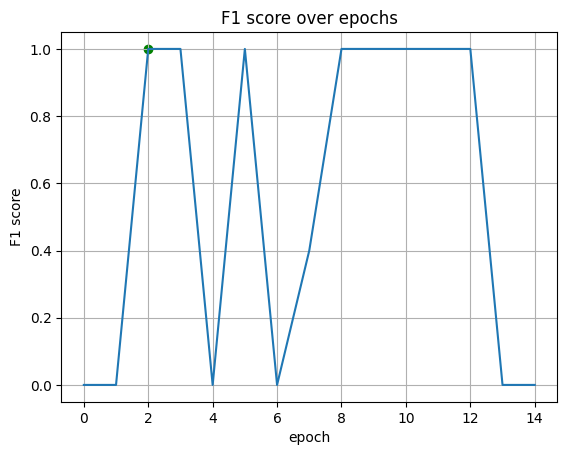

In [26]:
plt.plot(history['val_f1'])

plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix RAFT-WIKI-QA - validation')

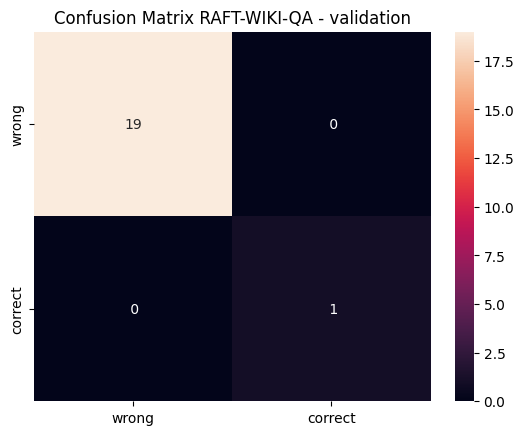

In [27]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - validation")

## Generating Test results

In [28]:
model = trainer.best_model
submission = pd.DataFrame()

with torch.no_grad():
    for i in tqdm(range(len(test['text']))):
        text = test['text'][i]
        label = test['label'][i]

        tokens = tokenizer(
            text,
            truncation= True,
            padding= "max_length",
            return_tensors= "pt",
            max_length=256,
        )

        for k,v in tokens.items():
            tokens[k] = v.to(device)

        pred = model(**tokens)\
            .logits\
            .argmax()\
            .to('cpu')\
            .item()

        this_row = pd.DataFrame({"predicted": pred, "label": label}, index = [i])

        submission = pd.concat([submission, this_row],)

100%|██████████| 1000/1000 [00:06<00:00, 153.70it/s]


In [29]:
submission

,predicted,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
995,0,0
996,0,0
997,0,0
998,0,0


In [30]:
from sklearn.metrics import f1_score, confusion_matrix

In [31]:
f1_score(submission['label'], submission['predicted'])

0.03636363636363636

Text(0.5, 1.0, 'Confusion Matrix RAFT-WIKI-QA - test')

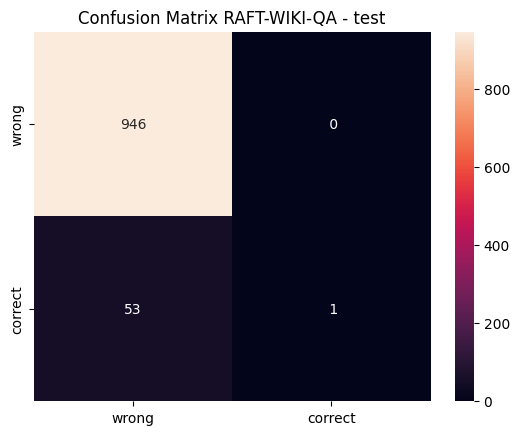

In [32]:
conf_matrix = confusion_matrix(
    submission['label'], 
    submission['predicted']
)

df = pd.DataFrame(
    conf_matrix,
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - test")

## General study - 500 shots

In [33]:
train_df

,question_id,question,document_title,answer,label,text
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0,how are glacier caves formed?A partly submerge...
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0,how are glacier caves formed?The ice facade is...
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0,how are glacier caves formed?Ice formations in...
3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1,how are glacier caves formed?A glacier cave is...
4,Q1,how are glacier caves formed?,Glacier cave,"Glacier caves are often called ice caves , but...",0,how are glacier caves formed?Glacier caves are...
...,...,...,...,...,...,...
20355,Q3043,what is section eight housing,Section 8 (housing),A tenant who leaves a subsidized project will ...,0,what is section eight housingA tenant who leav...
20356,Q3043,what is section eight housing,Section 8 (housing),The United States Department of Housing and Ur...,0,what is section eight housingThe United States...
20357,Q3044,what is the main type of restaurant,Category:Types of restaurants,Restaurants categorized by type and informatio...,0,what is the main type of restaurantRestaurants...
20358,Q3046,what is us dollar worth based on,History of the United States dollar,U.S. Federal Reserve notes in the mid-1990s,0,what is us dollar worth based onU.S. Federal R...


In [34]:
n_shots = 500
train_validation, test = stratified_train_test_split(
    train_df,
    classes,
    n_shots
)

In [35]:
train, val = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [36]:
val = pd.DataFrame(val).to_dict('list')
test = pd.DataFrame(test).sample(n = 1000).to_dict('list')

In [37]:
np.unique(train['label'], return_counts=True)

(array([0, 1]), array([284,  16]))

In [38]:
np.unique(val['label'],return_counts=True)

(array([0, 1]), array([190,  10]))

In [39]:
np.unique(test['label'],return_counts=True)

(array([0, 1]), array([939,  61]))

## Focal Loss Fn

In [40]:
_, class_counts = np.unique(
    train['label'],
    return_counts=True,
)

alpha = len(train['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val['label'],
    return_counts=True,
)
alpha_val = len(val['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test['label'],
    return_counts=True,
)
alpha_test = len(test['label'])/class_counts_test

In [41]:
alpha, alpha_val, alpha_test

(array([ 1.05633803, 18.75      ]),
 array([ 1.05263158, 20.        ]),
 array([ 1.06496273, 16.39344262]))

In [42]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [50]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "bert-base-uncased", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['label'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
    batch_size = 8
)


val_dataloader = get_dataloader(
    val['text'],
    val['label'],
    tokenizer,
    n_shots = 300,
    num_classes=num_classes,
    equalize_class=False,
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= binary_f1_score,
    n_epochs=30
)


Epoch 29
f1: 0.0
tensor([[188,   2],
        [ 10,   0]], device='cuda:0')


Text(0, 0.5, 'F1 score')

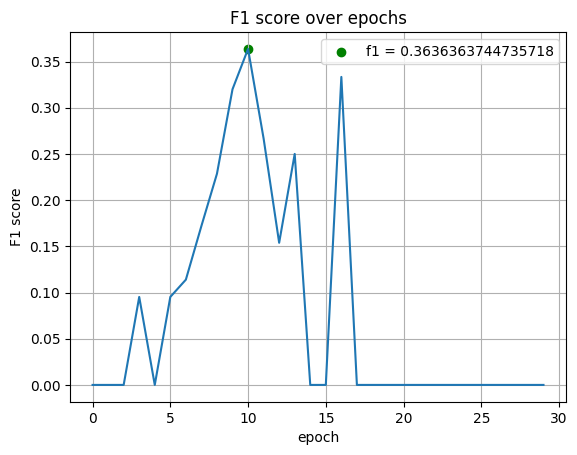

In [51]:
plt.plot(history['val_f1'])

plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.legend()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix RAFT-WIKI-QA - validation')

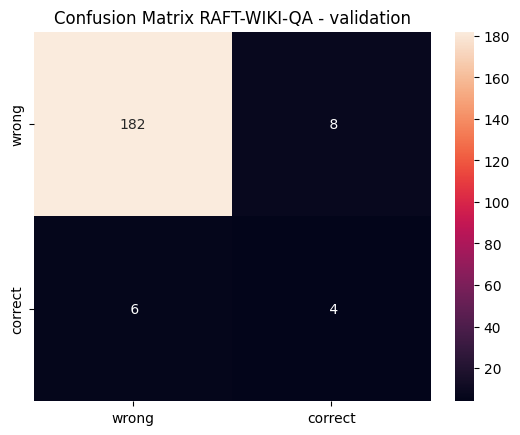

In [52]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - validation")

## Generating Test results

In [53]:
model = trainer.best_model
submission = pd.DataFrame()

with torch.no_grad():
    for i in tqdm(range(len(test['text']))):
        text = test['text'][i]
        label = test['label'][i]

        tokens = tokenizer(
            text,
            truncation= True,
            padding= "max_length",
            return_tensors= "pt",
            max_length=256,
        )

        for k,v in tokens.items():
            tokens[k] = v.to(device)

        pred = model(**tokens)\
            .logits\
            .argmax()\
            .to('cpu')\
            .item()

        this_row = pd.DataFrame({"predicted": pred, "label": label}, index = [i])

        submission = pd.concat([submission, this_row],)

100%|██████████| 1000/1000 [00:06<00:00, 145.96it/s]


In [54]:
submission

,predicted,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
995,0,0
996,0,0
997,0,0
998,0,0


In [55]:
from sklearn.metrics import f1_score, confusion_matrix

In [56]:
f1_score(submission['label'], submission['predicted'])

0.0963855421686747

Text(0.5, 1.0, 'Confusion Matrix RAFT-WIKI-QA - test')

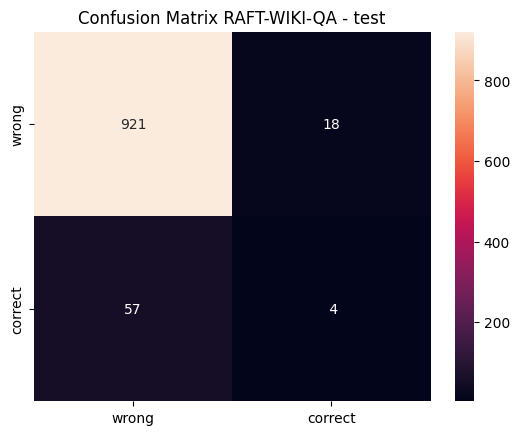

In [57]:
conf_matrix = confusion_matrix(
    submission['label'], 
    submission['predicted']
)

df = pd.DataFrame(
    conf_matrix,
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - test")